In [1]:
# Need this for matrix multiplication to work for some reason lol
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np

from classifier import MLPClassifier

import matplotlib.pyplot as plt

In [3]:
bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [4]:
# build model
mlp = MLPClassifier(x_dim=784, h_dim1= 256, h_dim2=64, out_dim=10)
if torch.cuda.is_available():
    mlp.cuda()

In [5]:
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

In [6]:
def train(epoch):
    mlp.train()
    train_loss = 0
    num_correct_tot = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        
        preds = mlp.forward(data.view(-1, 784)).argmax(1)
        num_correct = torch.sum(preds == target)
        num_correct_tot += num_correct
        
        #h1, h2, preds = mlp(data.reshape(data.shape[0], 784), return_latent=True)
        loss = mlp.loss_function(data, target)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data), 100 * num_correct / data.shape[0]))
            
    print('====> Epoch: {} Average loss: {:.4f} Average acc: {:.2f}'.format(
                epoch, train_loss / len(train_loader.dataset),
                100 * num_correct_tot / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset), 100 * num_correct_tot / len(train_loader.dataset)

def test():
    mlp.eval()
    test_loss= 0
    num_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            #preds = mlp(data.reshape(data.shape[0], 784))
            preds = mlp.forward(data.view(-1, 784)).argmax(1)
            num_correct += torch.sum(preds == target)
            # sum up batch loss
            test_loss += mlp.loss_function(data, target).item()
        
    test_loss /= len(test_loader.dataset)
    test_acc = 100 * num_correct / len(test_loader.dataset)
    print('====> Test set loss: {:.4f} Test Set acc: {:.2f}'.format(test_loss, test_acc))
    return test_loss, test_acc

In [7]:
test_losses = []
test_accs = []
train_losses = []
train_accs = []
epochs = range(1, 21)

In [8]:
for epoch in epochs:
    
    train_loss, train_acc = train(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    test_loss, test_acc = test()
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    

C:\Users\AlexGura\Documents\Research\Inversion\classifier.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc3(h2))


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.0187	Accuracy: 15.62
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.0015	Accuracy: 96.09
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0014	Accuracy: 95.31
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.0019	Accuracy: 92.97
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0015	Accuracy: 95.31
====> Epoch: 1 Average loss: 0.0022 Average acc: 92.70
====> Test set loss: 0.0014 Test Set acc: 95.42
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0012	Accuracy: 96.09
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.0012	Accuracy: 95.31
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0005	Accuracy: 98.44
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.0007	Accuracy: 96.88
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0018	Accuracy: 92.97
====> Epoch: 2 Average loss: 0.0013 Average acc: 95.74
====> Test set loss: 0.0013 Test Set acc: 95.85
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0009	Accuracy: 96.09
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.0008	Accuracy: 96.88
Train Epoch: 3 [25600/60000 (43%)]	Loss: 

Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.0029	Accuracy: 96.88
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.0019	Accuracy: 96.09
====> Epoch: 20 Average loss: 0.0008 Average acc: 98.07
====> Test set loss: 0.0016 Test Set acc: 97.17


Text(0, 0.5, 'Accuracy')

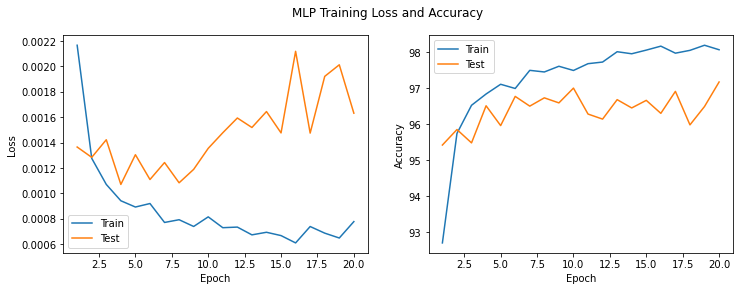

In [9]:
plt.rcParams["figure.figsize"] = (12,4)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MLP Training Loss and Accuracy')
x_ax = epochs
ax1.plot(x_ax, train_losses, label="Train")
ax1.plot(x_ax, test_losses, label="Test")
ax2.plot(x_ax, train_accs, label="Train")
ax2.plot(x_ax, test_accs, label="Test")
ax1.legend()
ax2.legend()
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

In [10]:
torch.save(mlp, "mlp.model")

In [11]:
mlp = torch.load("mlp.model")

In [12]:
data, target = next(iter(test_loader))

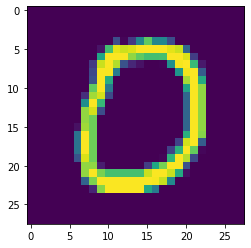

In [13]:
img_idx = 10
img = data[img_idx][0]
plt.imshow(img)
plt.show()
h1, h2, out = mlp.cpu().forward(data.view(-1, 784), return_latent=True)

In [14]:
encoded_dict = {
    "data": data.reshape((data.shape[0], 784)),
    "h1": h1,
    "h2": h2,
    "out": out,
    "target": target
}
torch.save(encoded_dict, "encoded_data.pt")

##### 

In [15]:
mlp.loss_function(data, target) / 128

tensor(0.0014, grad_fn=<DivBackward0>)

In [14]:
with torch.no_grad():
    num_correct = 0
    num = 0
    for i, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        preds = mlp.forward(data.view(-1, 784)).argmax(1)
        num += preds.shape[0]
        num_correct += torch.sum(preds == target)
    print(num_correct / num)

tensor(0.9437)


In [44]:
# Get a new dataset of all zeros
for digit in range(10):
    data_digit = torch.cat([entry[0].reshape(1, 784) for entry in test_loader.dataset if entry[1] == digit])
    h1_digit, h2_digit, out_digit = mlp.cpu().forward(data_digit, return_latent=True)
    encoded_dict_digit = {
        "data": data_digit,
        "h1": h1_digit,
        "h2": h2_digit,
        "out": out_digit,
    }
    torch.save(encoded_dict_digit, f"./digit_data/encoded_data_{digit}.pt")

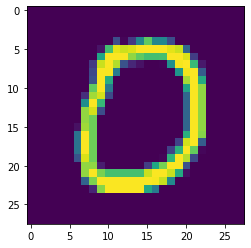

In [41]:
plt.imshow(data_zeros[1].reshape(28,28))